# **Background and Foreground Subtraction**

#### **Iremos aprender**
1. Background Subtraction com Algoritmo Gaussian Mixture-based Background/Foreground Segmentation 
2. Melhoramento adaptivo do modelo Gaussian Mixture para background subtraction

**Taken fron the OpenCV Docs**



A subtração de fundo (BS) é uma técnica comum e amplamente utilizada para gerar uma máscara de primeiro plano (ou seja, uma imagem binária contendo os pixels pertencentes a objetos em movimento na cena) usando câmeras estáticas.

Como o nome sugere, o BS calcula a máscara de primeiro plano realizando uma subtração entre o quadro atual e um modelo de fundo, contendo a parte estática da cena ou, mais em geral, tudo o que pode ser considerado como fundo dadas as características da cena observada.

![](https://docs.opencv.org/3.4/Background_Subtraction_Tutorial_Scheme.png)

Background modeling consists of two main steps:

1. Background Initialization;
2. Background Update.

Na primeira etapa é calculado um modelo inicial do fundo, enquanto na segunda etapa esse modelo é atualizado para se adaptar a possíveis mudanças na cena.


In [1]:
# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import numpy as np
from matplotlib import pyplot as plt
#from google.colab.patches import cv2_imshow

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

!wget https://github.com/rajeevratan84/ModernComputerVision/raw/main/walking_short_clip.mp4

'wget' is not recognized as an internal or external command,
operable program or batch file.


# **O que é Subtraçção de fundo  (Background Subtraction)?**

A subtração de fundo é uma técnica de visão computacional onde procuramos isolar o fundo do primeiro plano “em movimento”. Considere veículos atravessando uma estrada ou pessoas andando em uma calçada.

Parece simples em teoria (ou seja, basta manter os pixels da estação e remover os que estavam mudando). No entanto, coisas como mudanças nas condições de iluminação, sombras, etc. podem tornar as coisas mais complicadas.

Vários algoritmos foram introduzidos para esse propósito. A seguir, daremos uma olhada em dois algoritmos do módulo **bgsegm**.

### **Gaussian Mixture-based Background/Foreground Segmentation Algorithm**

In this paper, we propose a background subtraction (BGS) method based on the Gaussian mixture models using color and depth information. For combining color and depth information, we used the probabilistic model based on Gaussian distribution. In particular, we focused on solving color camouflage problem and depth denoising. For evaluating our method, we built a new dataset containing normal, color camouflage and depth camouflage situations. The dataset files consist of color, depth and ground truth image sequences. With these files, we compared the proposed algorithm with the conventional color-based BGS techniques in terms of precision, recall and F-measure. As a result, our method showed the best performance. Thus, this technique will help to robustly detect regions of interest as pre-processing in high-level image processing stages.


Link to Paper - https://www.researchgate.net/publication/283026260_Background_subtraction_based_on_Gaussian_mixture_models_using_color_and_depth_information


O MOG modela cada pixel de uma cena como uma mistura de várias distribuições Gaussianas. Isso permite que ele se adapte a mudanças dinâmicas no fundo, como árvores se movendo ao vento ou sombras.


- history:Número de quadros usados para modelar o fundo. Valores maiores permitem que o modelo se adapte melhor a mudanças no fundo.

- nmixtures:Número de distribuições Gaussianas usadas para modelar cada pixel.

- backgroundRatio: Limite para decidir se um pixel pertence ao fundo ou ao primeiro plano. É uma razão entre a probabilidade do fundo e a probabilidade total.

- noiseSigma:Controla o desvio padrão inicial das distribuições Gaussianas. Valores maiores aumentam a sensibilidade a ruídos.


# Mixture of Gaussians (MOG) - Explicação Matemática

O **Mixture of Gaussians (MOG)** é um modelo probabilístico que descreve a distribuição dos valores de intensidade de um pixel ao longo do tempo em uma sequência de imagens. Ele utiliza uma mistura de distribuições gaussianas para diferenciar entre **fundo** (background) e **primeiro plano** (foreground).

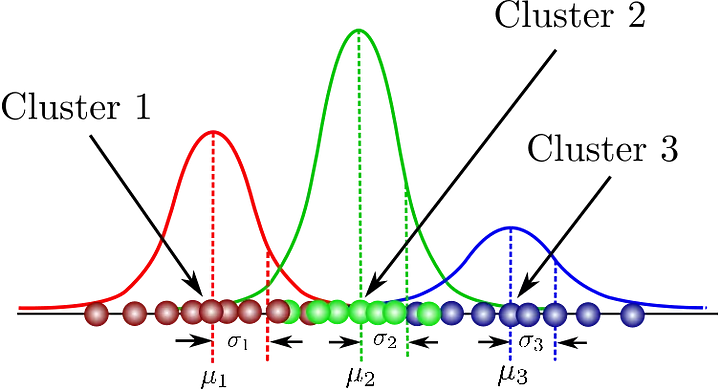

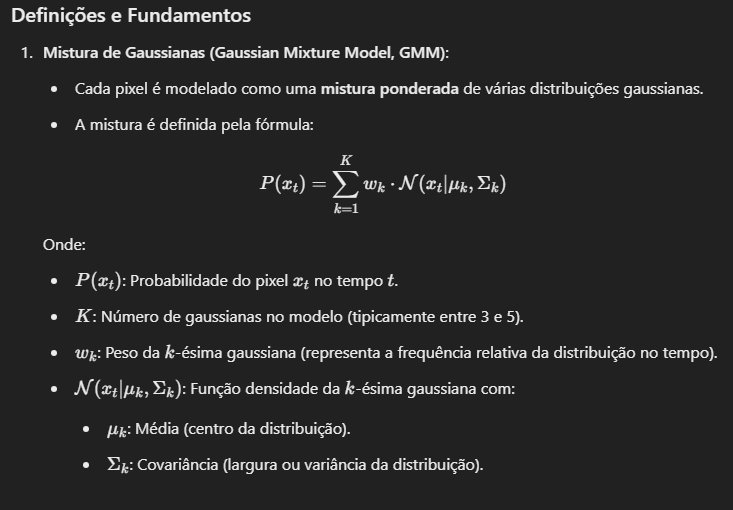

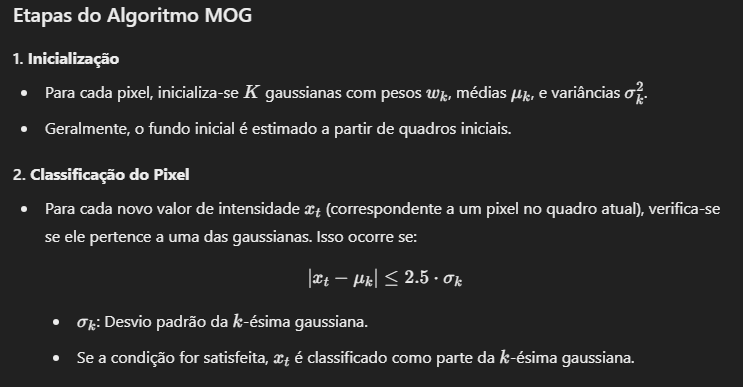

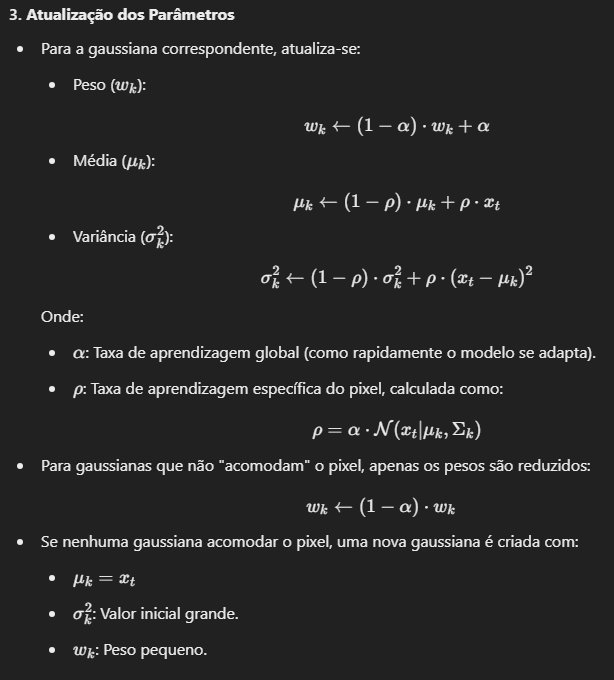

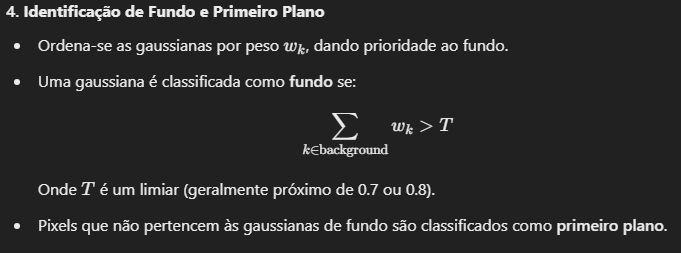

In [2]:
cap = cv2.VideoCapture('images/RodoviaCoreia.mp4')

# Get the height and width of the frame (required to be an interger)
w = int(cap.get(3)) 
h = int(cap.get(4))

# Definindo o CODEC e o video de saida
out = cv2.VideoWriter('Rodovia-Coreia-MOG.mp4', cv2.VideoWriter.fourcc('m','p','4','v'), 30, (w, h), isColor=False)

# Aplicando o MIXTURE OF GAUSSIANS
foreground_background = cv2.bgsegm.createBackgroundSubtractorMOG()


# aplicando para cada frame
while True:
    
    ret, frame = cap.read()
    

    if ret: 
      # Apply background subtractor to get our foreground mask
      foreground_mask = foreground_background.apply(frame)
      #imshow("Foreground Mask", foreground_mask)
      out.write(foreground_mask)
    else:
      break

cap.release()
out.release()

### **Let's try the Improved adaptive Gausian mixture model for background subtraction**

Background subtraction is a common computer vision task. We analyze the usual pixel-level approach. We develop an efficient adaptive algorithm using Gaussian mixture probability density. Recursive equations are used to constantly update the parameters and but also to simultaneously select the appropriate number of components for each pixel.

https://www.researchgate.net/publication/4090386_Improved_Adaptive_Gaussian_Mixture_Model_for_Background_Subtraction


cv2.bgsegm.createBackgroundSubtractorGSOC é uma função do módulo bgsegm da biblioteca OpenCV. Ela cria um objeto para segmentação de fundo baseado no método GSOC (Graph Signal Optimal Clustering). É uma versão adaptativa do MOG. 

Esse algoritmo é utilizado para subtração de fundo em vídeos ou fluxos de imagens, destacando objetos em movimento ao separar o primeiro plano do fundo estático.

- Modelagem da Cena como um Grafo
    - Representação em Grafo: Cada pixel da imagem é tratado como um nó em um grafo.
    As conexões entre os nós (arestas) são baseadas em critérios como proximidade espacial e similaridade de cor ou intensidade.
    Essas conexões criam uma estrutura que captura relações entre pixels vizinhos.

    - Atributos do Grafo: Cada aresta tem um peso associado, que reflete a similaridade entre dois pixels conectados. Quanto maior a similaridade, maior o peso.

- Análise Temporal de Mudanças
    - O método compara os sinais associados aos pixels em diferentes quadros do vídeo.
    
    - Sinais temporais de intensidade (ou cor) são analisados para detectar mudanças significativas, como movimento de objetos.

    - Redução de Ruído Temporal: Pequenas variações, como oscilações de iluminação, são filtradas para evitar falsos positivos.

- Segmentação Baseada em Clustering
    - Agrupamento de Pixels (Clustering): Pixels que apresentam comportamento semelhante no tempo (por exemplo, movimento sincronizado) são agrupados em clusters. Isso ajuda a identificar áreas de movimento como regiões coerentes, em vez de pixels individuais.

    - Separação Primeiro Plano/Fundo: O fundo é modelado como as partes estáticas da cena, enquanto os clusters dinâmicos são classificados como primeiro plano.


- Atualização Dinâmica do Modelo
    - Adaptação Contínua: O modelo de fundo é atualizado em tempo real para se adaptar a mudanças graduais na cena, como: Alterações na iluminação. Introdução de novos objetos estáticos (por exemplo, um carro estacionado).

    - Esquecimento do Passado: Informações antigas, que não são mais relevantes, são descartadas para otimizar o desempenho.

- Pós-Processamento
    - Refinamento das Máscaras: A máscara do primeiro plano gerada é suavizada para remover ruídos e pequenas inconsistências.

    - Preenchimento de Lacunas: Áreas mal detectadas dentro dos objetos em movimento são preenchidas para obter contornos mais consistentes.

    - Filtragem Morfológica: Operações como dilatação ou erosão podem ser aplicadas para melhorar a qualidade da máscara.


# Parâmetros da Função `cv2.bgsegm.createBackgroundSubtractorGSOC`

A função `cv2.bgsegm.createBackgroundSubtractorGSOC` no OpenCV oferece parâmetros configuráveis para ajustar o comportamento do algoritmo GSOC em diferentes cenários. Abaixo estão os principais parâmetros e suas descrições:

## 1. Parâmetros principais

### `mc` *(float, opcional)*
- **Descrição:** Controla a sensibilidade do modelo ao movimento.
- **Valor padrão:** Ajustado internamente pelo algoritmo.
- **Impacto:** 
  - Valores mais altos: Maior sensibilidade ao movimento.
  - Valores mais baixos: Modelo mais conservador.

---

### `nSamples` *(int, opcional)*
- **Descrição:** Número de amostras usadas para estimar o fundo.
- **Valor padrão:** Geralmente entre 5 e 20.
- **Impacto:** 
  - Maior número de amostras: Mais precisão, mas maior consumo de memória e processamento.

---

### `replaceRate` *(float, opcional)*
- **Descrição:** Taxa de substituição das amostras do fundo.
- **Valor padrão:** Definido automaticamente.
- **Impacto:** 
  - Taxa mais alta: Adaptação mais rápida do fundo, mas pode introduzir instabilidade.

---

### `propagationRate` *(float, opcional)*
- **Descrição:** Controla a propagação das informações no modelo de fundo.
- **Impacto:** Afeta a suavização de ruídos e pequenas variações na imagem.

---

### `hitsThreshold` *(int, opcional)*
- **Descrição:** Número de vezes que um pixel precisa ser detectado como parte do fundo para ser considerado estático.
- **Impacto:** 
  - Valores mais altos: Melhor estabilidade em cenas com movimento repetitivo.

---

### `alpha` *(float, opcional)*
- **Descrição:** Controla a taxa de aprendizado para atualização do fundo.
- **Impacto:** 
  - Valores mais baixos: Aprendizado mais lento.
  - Valores mais altos: Adaptação mais rápida.

---

### `beta` *(float, opcional)*
- **Descrição:** Impacta a sensibilidade do modelo às variações temporais.
- **Impacto:** 
  - Valores mais altos: Maior sensibilidade a mudanças rápidas.

---

### `blinkThreshold` *(int, opcional)*
- **Descrição:** Número de quadros consecutivos que um pixel deve mudar para ser considerado parte do primeiro plano.
- **Impacto:** 
  - Reduz falsos positivos causados por oscilações rápidas de iluminação.

---

Modelagem Matemática

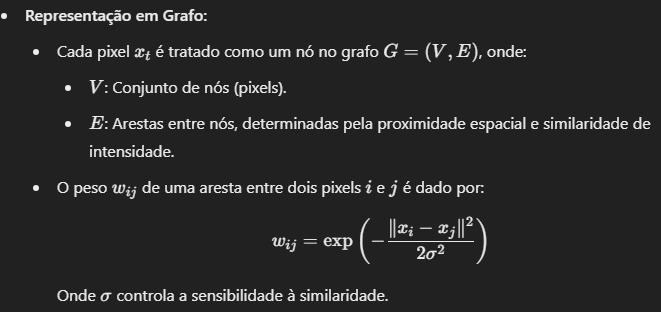

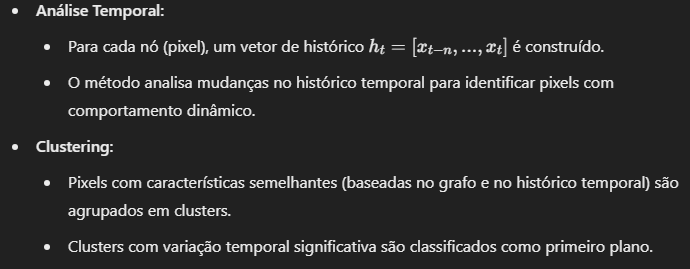

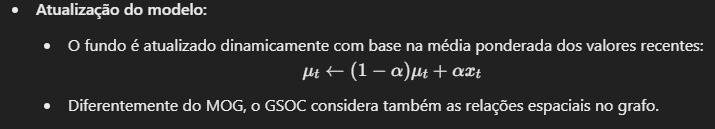


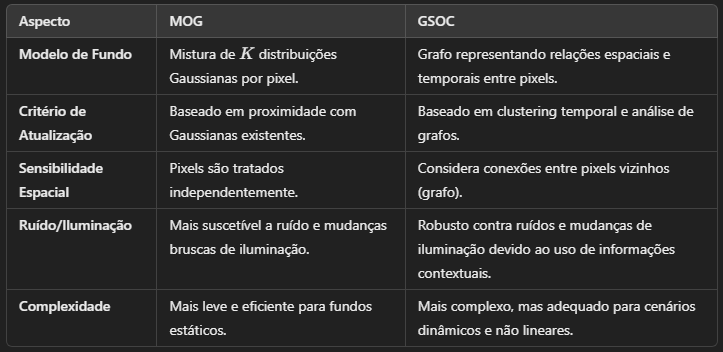

In [3]:
cap = cv2.VideoCapture('images/RodoviaCoreia.mp4')

# Pega o shape
w = int(cap.get(3))
h = int(cap.get(4))

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('Rodovia-Coreia-GSOC.mp4', cv2.VideoWriter.fourcc(*'MP4V'), 30, (w, h), isColor=False)

# Initlaize background subtractor
foreground_background = cv2.bgsegm.createBackgroundSubtractorGSOC()

# Loop once video is successfully loaded
while True:
    
    ret, frame = cap.read()
    if ret: 
      # Apply background subtractor to get our foreground mask
      foreground_mask = foreground_background.apply(frame)
      out.write(foreground_mask)
      #imshow("Foreground Mask", foreground_mask)
    else:
      break

cap.release()
out.release()

## **Foreground Subtraction** 

1. Como funciona a média ponderada acumulativa
A cada novo frame, o valor de cada pixel no modelo acumulado (average) é atualizado de acordo com a fórmula:

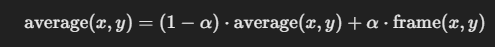

    average(x, y): Valor acumulado do pixel no modelo de fundo até o momento.

    frame(x, y): Valor atual do pixel no frame atual.

    α (alpha): Peso da atualização, que controla a "velocidade" com que o fundo é atualizado.
Se α é pequeno (ex.: 0.01), o modelo de fundo muda devagar, absorvendo gradualmente novos valores.


2. Por que o fundo desaparece?
Se algo em uma cena está parado (ex.: uma parede, móveis, ou qualquer fundo estático), os valores desses pixels no frame se tornam gradualmente os mesmos valores no average. Com o tempo, isso cria um "modelo do fundo" que reflete o que não muda na cena.

Se um objeto ou pessoa em movimento desaparece da cena (por exemplo, sai do campo de visão da câmera), os pixels correspondentes aos novos frames (sem o objeto) começam a ser incorporados ao modelo.
O fundo acumulado substitui gradualmente os valores antigos do objeto desaparecido pelos valores do novo fundo que "apareceu" no lugar.

3. O que acontece com os pixels?
A técnica suaviza os valores de cada pixel ao longo do tempo, atribuindo mais peso aos valores recentes (dependendo de α). Isso faz com que:

Objetos móveis: Objetos que aparecem temporariamente na cena (ex.: uma pessoa andando) não sejam incorporados ao modelo acumulado imediatamente. Em vez disso, eles desaparecem gradualmente à medida que os pixels retornam ao valor do fundo.

Fundo estático: O fundo estático (ex.: paredes, chão) permanece consistente no modelo acumulado, pois seus valores nos frames não mudam significativamente.

Rápidas mudanças: Se α é alto (próximo de 1), o modelo reage rapidamente às mudanças. Isso pode fazer com que até mesmo pequenas alterações sejam absorvidas no modelo rapidamente, fazendo o fundo parecer instável.

In [4]:
cap = cv2.VideoCapture('images/RodoviaCoreia.mp4')

# Get the height and width of the frame (required to be an interfer)
w = int(cap.get(3))
h = int(cap.get(4))

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
# isColor pois temos cores agora, ou seja, 3 canais. 
out = cv2.VideoWriter('Rodovia-Coreia-MEDIAPONDERADA.mp4', cv2.VideoWriter_fourcc('M','P','4','V'), 30, (w, h), isColor=True)
ret, frame = cap.read()

# Create a flaot numpy array with frame values
average = np.float32(frame)

while True:
    # Get frame
    ret, frame = cap.read()

    if ret: 
      
      #é usada para calcular uma média ponderada acumulativa de imagens.
      #  Essa função é especialmente útil para aplicações como remoção de fundo ou detecção de movimento em vídeos.
      # 0,01 é o peso da imagem, brinque para ver como ela muda
      # 0,01 é peso para a média. Um valor menor faz as mudanças no modelo acumulado serem mais lentas.
      #  Isso suaviza variações ao longo do tempo, permitindo criar um modelo de fundo gradual 
      # (útil para remover o fundo ou suavizar imagens).
      cv2.accumulateWeighted(frame, average, 0.01)
      
      # Dimensiona, calcula valores absolutos e converte o resultado para 8 bits
      background = cv2.convertScaleAbs(average)

      #imshow('Input', frame)
      #imshow('Disapearing Background', background)
      out.write(background)

    else:
      break

cap.release()
out.release()

In [6]:
cv2_imshow(background)

NameError: name 'cv2_imshow' is not defined

### **Background Substraction KKN**

Os parâmetros se você deseja desviar das configurações padrão:

- **history** é o número de quadros usados ​​para construir o modelo estatístico do fundo. Quanto menor o valor, mais rápidas as mudanças no fundo serão levadas em conta pelo modelo e, portanto, serão consideradas como fundo. E vice-versa.
- **dist2Threshold** é um limite para definir se um pixel é diferente do fundo ou não. Quanto menor for o valor, mais sensível será a detecção de movimento. E vice-versa.
- **detectShadows** : Se definido como verdadeiro, as sombras serão exibidas em cinza na máscara gerada. (Exemplo abaixo)

https://docs.opencv.org/master/de/de1/group__video__motion.html#gac9be925771f805b6fdb614ec2292006d


cv2.createBackgroundSubtractorKNN() cria um objeto para realizar subtração de fundo utilizando o algoritmo K-Nearest Neighbors (KNN).

Como funciona?
Histórico de pixels:

Cada pixel é analisado com base em um histórico recente de frames.
Para determinar se um pixel pertence ao fundo, ele é comparado com os valores dos últimos k pixels (definido pelo parâmetro kNNSamples).

Classificação:
Se o valor de um pixel no frame atual for semelhante ao valor de pelo menos k pixels no histórico, ele é classificado como parte do fundo. Caso contrário, ele é classificado como foreground (objeto em movimento).

Atualização do modelo:
O modelo de fundo é atualizado dinamicamente para incorporar mudanças lentas, como iluminação ou pequenas alterações no cenário.

In [7]:
cap = cv2.VideoCapture('images/walking.avi')

# Get the height and width of the frame (required to be an interfer)
w = int(cap.get(3))
h = int(cap.get(4))

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('walkingKNNBGSeg.avi', cv2.VideoWriter.fourcc('M','J','P','G'), 30, (w, h), isColor=False)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fgbg = cv2.createBackgroundSubtractorKNN()

while(1):
    ret, frame = cap.read()

    if ret:
      fgmask = fgbg.apply(frame)
      fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

      #imshow('frame', fgmask)
      out.write(fgmask)
    else:
      break

cap.release()
out.release()